In [1]:
import rheoflow

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use(['dark_background'])

from ipywidgets import interact, fixed
from ipywidgets import widgets
from IPython.display import display, Math, Latex

# rheopy.laminar deep example with references

This notebook provides deep examples for using rheopy for pipe flow.  Both tube and slit flow examples with a variety of viscosity models are provided.  SI units units are used everywhere.  For the variables used here, the units are:

$\eta = \left< Pas \right>$

$\sigma = \left< Pa \right>$

$\dot{\gamma} = \left< s^{-1} \right>$

$\Delta P = \left< Pa \right>$

$Q = \left< \frac{m^3}{s} \right>$

$v_z = \left< \frac{m}{s} \right>$

$length = \left< m \right>$

$radius = \left< m \right>$

## Calculation procedure

The rheopy.laminar notebook is intended to work with any viscosity model.  There are four elemenets of computation:

1. A viscosity model using the class structure provided - $\eta(\dot{\gamma})$
2. Shear rate calculation at any radial position (tube) or height (slit) - $\dot{\gamma}(r)$
3. Velocity calculation at any position - $v_z(r)$
4. Volumetric flow rate - $Q$, given $\Delta P$ (or vice versa)

## Details of calculations

### 1 - Viscosity model
Use pre-existing, or create new function with viscosity as a function of shear rate:

$\eta \left[ \dot{\gamma} \right]$

### 2 - Shear rate calculation ($\dot{\gamma}$)
The equation to be solved for shear rate at any radial position is

$\eta \left[ \dot{\gamma}(r) \right] \dot{\gamma}(r) = \frac{r}{2} \frac{\Delta P}{L}$,

where $\dot{\gamma}(r) = \frac{d v_z(r)}{dr}$

This equation is simply an equality of shear stress from constituitve model and shear stress from a momentum balance.  This calculation is numerical in rheopy because this equation does not always have analytical solutions.  The Carreau viscosity model is an example where an analytical solution does not yet exist.  

Note that 4 inputs are required: 
1. Viscosity model - $\eta(\dot{\gamma})$
2. Tube radius
3. Tube length
4. Pressure drop ($\Delta P$)

### 3 - Velocity calculation ($v_z$)
The axial velocity is calculated from the shear rate directly

$v_z(r) = -\int_{r}^{R} \dot{\gamma}(r)dr$

This integral is computed numerically beacuse the shear rate is computed numerically.

### 4 - Volumetric flow rate ($Q$)
The volumetric flow rate is computed by numerically integrating the velocity profile

$Q = 2\pi \int_{0}^{R} v_z(r)rdr$

Note that if Q is an input, then $\Delta P$ must be solved for iteratively.  

## Viscosity model class structure

The actual class of power_law is shown below.  Any viscosity model class must have three features:
1. A __init__ method to initialize an object
2. A __str__ method to print the object (not actually required)
3. A calc_visc method for computing the viscosity for input shear rate

In [9]:
class power_law(rheoflow.viscosity.property_plot):
    def __init__(self,name='Default',k=1.,n=.5):
        self.name = name
        self.k = k
        self.n = n
        
    def __str__(self):
        return str(self.name+'\n'+
            'k ='+str(self.k)+'\n'+
            'n='+str(self.n)+'\n')
        
    def calc_visc(self,rate):
        return self.k*(rate+1.e-9)**(self.n-1.)

An instance, pl_viscosity, of the power_law class is created. The object is printed, showing parameter values.  The viscosity at a shear rate of 150 $s^{-1}$ is computed.

In [10]:
pl_viscosity = power_law(name='My example power-law',k=2.0,n=0.7)

In [11]:
print(pl_viscosity)

My example power-law
k =2.0
n=0.7



In [12]:
pl_viscosity.calc_visc(rate=150.)

0.4448387563894917

The inherited laminar.property_plot provides convenience methods.  For example viscosity_plot and stress_plot are ised here.  The min and max shear rate range in the plot are .001 and 10,000.

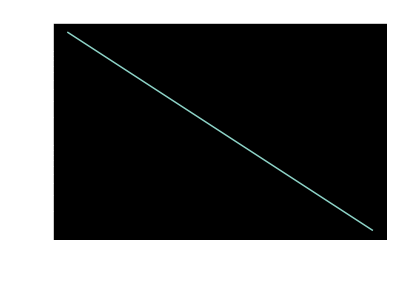

In [13]:
pl_viscosity.visc_plot()

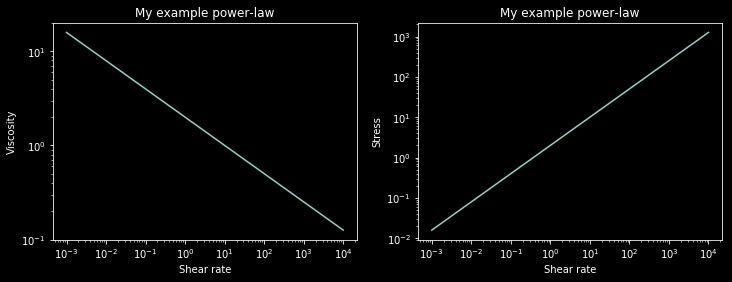

In [8]:
plt.figure(figsize=(12,4))
plt.subplot(121)
pl_viscosity.visc_plot()
plt.subplot(122)
pl_viscosity.stress_plot()          

We can instantiate an object, rheopy_pl_viscosity, from rheopy.laminar that is the same.  It produces the same results.

In [15]:
rheoflow_pl_viscosity = rheoflow.viscosity.power_law(name='My rheopy power-law viscosity',k=2.0,n=0.7)

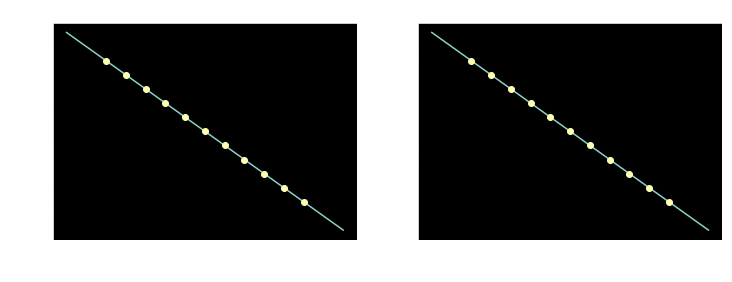

In [16]:
plt.figure(figsize=(12,4))

rate_list = np.logspace(-2,3,11)
visc_list = [pl_viscosity.calc_visc(rate=r) for r in rate_list]

plt.subplot(121)
pl_viscosity.visc_plot()
plt.plot(rate_list,visc_list,'o')
plt.subplot(122)
rheoflow_pl_viscosity.visc_plot() 
plt.plot(rate_list,visc_list,'o')

## Tube class structure and example

An instance of the class laminar_tube_flow is created.  The instance/object is called my_tube.  The object is created using the viscosity model pl_viscosity that we used above.

In [17]:
my_tube = rheoflow.pipe.laminar_tube_flow(name='My experimental tube',radius=.005,length=5.,viscosity=pl_viscosity)

AttributeError: module 'rheoflow.pipe' has no attribute 'laminar_tube_flow'

The object my_tube may be printed to see important variables.  Note that neither pressure drop or flow rate have been specified so nothing is computed.

In [12]:
print(my_tube)

Name =My experimental tube
Radius =0.005
Length =5.0
Pressure drop =None
Flow rate =None
Shear rate wall = None


Now we set a value of pressure drop tp 50,000 Pa.  Then when we print my_tube, a flow rate and shear rate are computed.

In [13]:
my_tube.pressure_drop = 500000.

In [14]:
print(my_tube)

Name =My experimental tube
Radius =0.005
Length =5.0
Pressure drop =500000.0
Flow rate =8.777724882195872e-05
Shear rate wall = 989.8872554795408


The variables (attributes) of my_tube may be accessed.  They are the same values as seen in the print statement.

In [15]:
my_tube.q = 1.e-4

In [16]:
my_tube.pressure_drop

547775.5316163056

In [17]:
my_tube.shear_rate_wall

1127.7264539099242

In [18]:
my_tube.shear_stress_wall

273.8877658081528

In [19]:
my_tube.radius

0.005

Now we can change a variable, such as radius, and observe the new calculated values of my_tube.

In [20]:
my_tube.radius = .01

In [21]:
print(my_tube)

Name =My experimental tube
Radius =0.01
Length =5.0
Pressure drop =547775.5316163056
Flow rate =0.0021534403082110114
Shear rate wall = 3035.6145031072174


In [22]:
my_tube.radius = .005
my_tube.length = 2.0

In [23]:
print(my_tube)

Name =My experimental tube
Radius =0.005
Length =2.0
Pressure drop =547775.5316163056
Flow rate =0.0003702420369929952
Shear rate wall = 4175.317394665526


### Change length example
We can also create lists of variables, such as tube length.  Then we can explore and plot in a pythonic way.  Here we create a list, length_list, with values from 1-10 m.  Then we plot the resulting changes.

Note that pressure drop does not change unless we explicitly change the flow rate to a new value.  So pressure drop does not change in the first plot.  However, flow rate changes with length in the second plot.

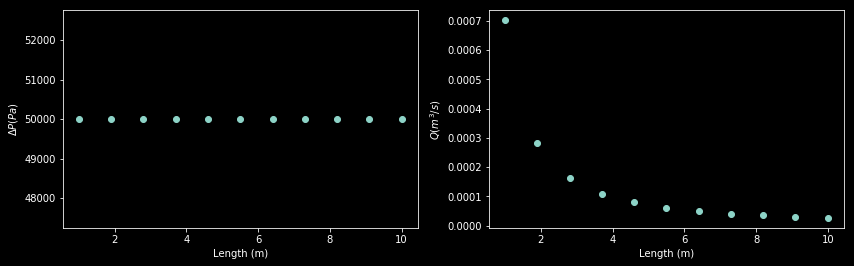

In [24]:
length_list = np.linspace(1.,10.,11)
my_tube.q = 1.e-6
my_tube.pressure_drop = 50000.
my_tube.radius = .01

dp_list = [my_tube.pressure_drop for my_tube.length in length_list]
q_list = [my_tube.q for my_tube.length in length_list]

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(length_list,dp_list,'o')
plt.xlabel('Length (m)')
plt.ylabel('$\Delta P (Pa)$');
plt.subplot(122)
plt.plot(length_list,q_list,'o')
plt.xlabel('Length (m)')
plt.ylabel('$Q (m^3/s)$');

### Change radius example
We can also create lists of variables, such as tube radius.  Then we can explore and plot in a pythonic way.  Here we create a list, radius_list, with values from .002-0.22 m.  Then we plot the resulting changes.

Note that pressure drop does not change unless we explicitly change the flow rate to a new value.  So pressure drop does not change in the first plot.  However, flow rate changes with radius in the second plot.

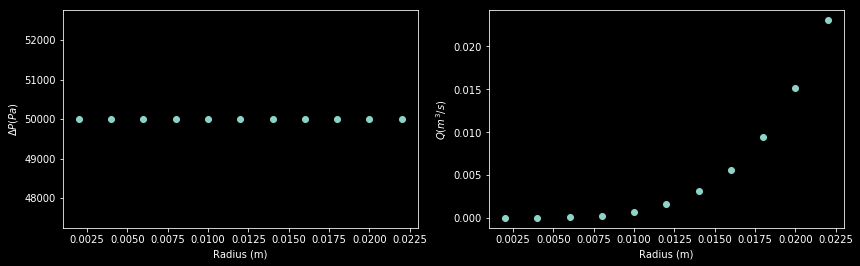

In [25]:
radius_list = np.linspace(.002,.022,11)
my_tube.q = 1.e-6
my_tube.pressure_drop = 50000.
my_tube.length = 1.
dp_list = [my_tube.pressure_drop for my_tube.radius in radius_list]
q_list = [my_tube.q for my_tube.radius in radius_list]

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(radius_list,dp_list,'o')
plt.xlabel('Radius (m)')
plt.ylabel('$\Delta P (Pa)$');
plt.subplot(122)
plt.plot(radius_list,q_list,'o')
plt.xlabel('Radius (m)')
plt.ylabel('$Q (m^3/s)$');

## Carreau viscosity model example

The Carreau viscosity model may be expressed with four parameters as:

$ \eta \left( \dot{\gamma} \right) = \eta_{\infty}+ \frac{\eta_0-\eta_{\infty}}{\left( \left( 1+\left(\lambda \dot{\gamma} \right)^a \right) \right)^{\frac{1-n}{n}}} $

To instantiate an object of class Carreau, we use

In [26]:
my_carreau_model = rheopy.laminar.carreau('My first Carreau model',
                                   eta0=5.,etainf=.11,reltime=.02,a=1.3,n=.3)

To compute the viscosity at a specified shear rate, we use the calc_visc(rate) method

In [27]:
my_carreau_model.calc_visc(rate=10.)

4.7030017198606435

To view the model parameters, we use the print method

In [28]:
print(my_carreau_model)

My first Carreau model
eta0 =5.0
etainf =0.11
reltime =0.02
a =1.3
n=0.3



To plot the viscosity versus shear rate on a log-log plot, we use the method visc_plot(rate_min,rate_max), which is inherited from the Property_plot class.

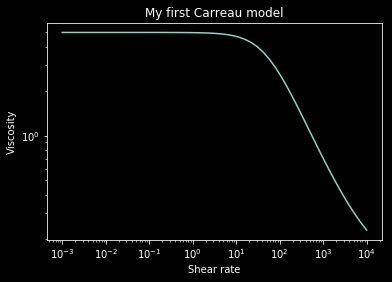

In [29]:
my_carreau_model.visc_plot()

## Laminar pipe flow - Carreau viscosity model

We will instantiate an object my_carreau_tube with a few properties and also use the object my_carreau_model to specifiy the viscosity behavior.

In [30]:
my_carreau_tube = rheopy.laminar.laminar_tube_flow('my laminar flow pipe',density=1000.,
                               radius=.01,length=1.0,viscosity=my_carreau_model)

Set the pressure drop to 20,000 Pa

In [31]:
my_carreau_tube.pressure_drop = 20000.

Check the object propperties by using print

In [32]:
print(my_carreau_tube)

Name =my laminar flow pipe
Radius =0.01
Length =1.0
Pressure drop =20000.0
Flow rate =1.7826919711718616e-05
Shear rate wall = 23.673966897448764


We can check the viscosity model used by my_carreau_tube

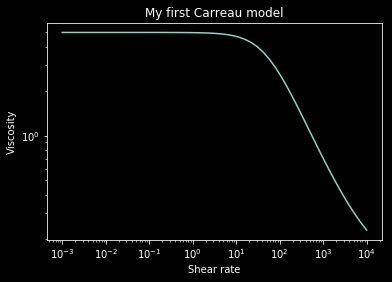

In [33]:
my_carreau_tube._viscosity.visc_plot()

### Shear rate calculation

The shear rate at any radial position between r=0 and r=radius is essential to all calculations here.  We will calculate the shear rate at the radial position of the outer wall, r=radius.  There are three different ways to do this.

In [34]:
my_carreau_tube.shear_rate_wall

23.673966897448764

In [35]:
my_carreau_tube.shear_stress_wall

100.0

There is a method to plot the shear rate as a function of radial position, shear_rate_plot()

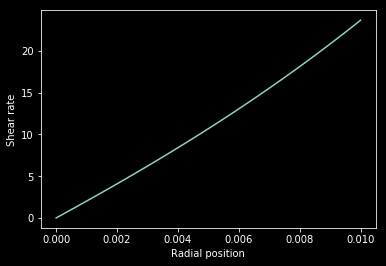

In [36]:
my_carreau_tube.shear_rate_plot()

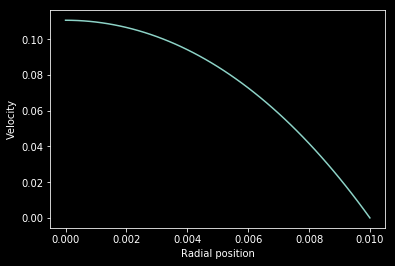

In [37]:
my_carreau_tube.vz_plot()

### Flow rate versus pressure drop

The flow rate may be calculated as a function of pressure drop, or pressure drop as a function of flow rate.  Both are shown here.  Finally a log-log plot of pressure drop as a function of flowrate is shown.

In [38]:
my_carreau_tube.pressure_drop

20000.0

In [39]:
my_carreau_tube.q

1.7826919711718616e-05

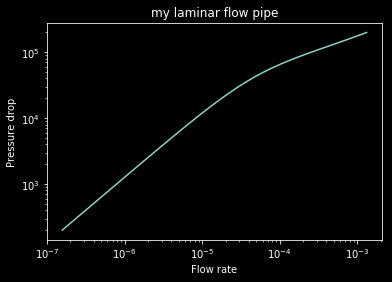

In [40]:
my_carreau_tube.q_plot(pressure_drop_min=200.,pressure_drop_max=200000.)

### Interactive plots
Here we show interactive plots. The object my_carreau_tube is used.  The following three plots are created:
1. $\eta(\dot{\gamma})$ versus $\dot{\gamma}$
2. $\dot{\gamma}$ versus radial position
3. $v_z$ versus radial position

A dot is shown on plot 1 that represents the wall shear rate in the pipe.  Teh Carreau model relaxation time and shear thining index n along with pressure drop are parameters.

In [41]:
def carreau_interactive(pipe,reltime,n,dp):
    pipe._viscosity.n = n
    pipe._viscosity.reltime=reltime
    pipe.pressure_drop=dp
    plt.figure(figsize=(16,4))
    plt.subplot(131)
    pipe._viscosity.visc_plot()
    plt.plot(pipe.shear_rate_wall,pipe.viscosity_wall(),'o')
    plt.subplot(132)
    pipe.shear_rate_plot()
    plt.subplot(133)
    pipe.vz_plot()

interact(carreau_interactive,pipe=fixed(my_carreau_tube),reltime=(.01,1.),n=(0.1,1.),dp=(5000.,40000.),
        continuous_update=False)

interactive(children=(FloatSlider(value=0.505, description='reltime', max=1.0, min=0.01), FloatSlider(value=0.55, description='n', max=1.0, min=0.1), FloatSlider(value=22500.0, description='dp', max=40000.0, min=5000.0), Output()), _dom_classes=('widget-interact',))

<function __main__.carreau_interactive>

## Laminar pipe flow - 3-Comp viscosity model

The 3-component viscosity model may be expressed with three parameters as:

$ \eta \left( \dot{\gamma} \right) = \frac{\tau_y}{\dot{\gamma}} + \frac{\tau_y}{\dot{\gamma}}\left( \frac{\dot{\gamma}_{crit}}{\dot{\gamma}}\right)^n + \eta_{bg} $

To instantiate an object of class Three_component, we use

In [42]:
my_3c_viscosity = rheopy.laminar.three_component('my 3-comp viscosity model',tauy=100.,gamma_crit=10., eta_bg=1.,m=1000.)

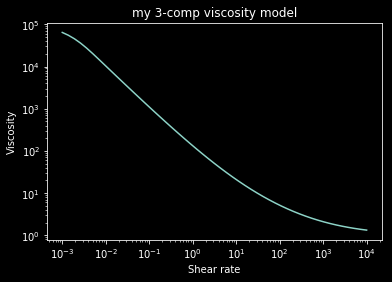

In [43]:
my_3c_viscosity.visc_plot()

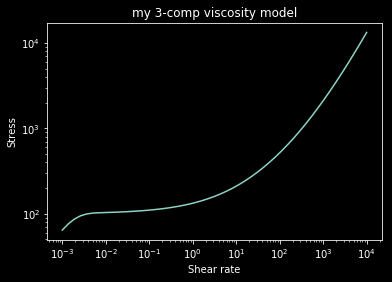

In [44]:
my_3c_viscosity.stress_plot()

In [45]:
my_3c_viscosity.gamma_crit

10.0

In [46]:
def my_3c_stress(viscosity_model,tauy,gamma_crit,eta_bg,m):
    viscosity_model.eta_bg = eta_bg
    viscosity_model.gamma_crit = gamma_crit
    viscosity_model.tauy = tauy
    viscosity_model.m = m
    viscosity_model.stress_plot()

interact(my_3c_stress,viscosity_model=fixed(my_3c_viscosity),tauy=(0.,100.),gamma_crit=(.01,1000.)
         ,eta_bg=(.1,100.),m=(100.,1000),continuous_update=False)

interactive(children=(FloatSlider(value=50.0, description='tauy'), FloatSlider(value=500.005, description='gamma_crit', max=1000.0, min=0.01), FloatSlider(value=50.050000000000004, description='eta_bg', min=0.1), FloatSlider(value=550.0, description='m', max=1000.0, min=100.0), Output()), _dom_classes=('widget-interact',))

<function __main__.my_3c_stress>

In [47]:
my_3c_pipe = rheopy.laminar.laminar_tube_flow('my 3-comp pipe',density=1000.,
                                  radius=.01,length=1.,viscosity=my_3c_viscosity)

In [48]:
my_3c_pipe.pressure_drop = 200000.

In [49]:
print(my_3c_pipe)

Name =my 3-comp pipe
Radius =0.01
Length =1.0
Pressure drop =200000.0
Flow rate =1.4474359676438283e-05
Shear rate wall = 18.78737154067596


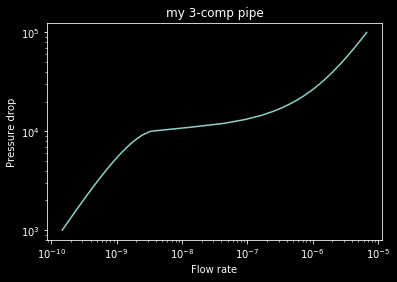

In [50]:
my_3c_pipe.q_plot(1000.,100000.)

In [51]:
my_3c_pipe.pressure_drop=50000.
my_3c_pipe.q

2.8043154891387624e-06

In [52]:
my_3c_pipe.q = 8.4884e-6
my_3c_pipe.pressure_drop

123191.283782795

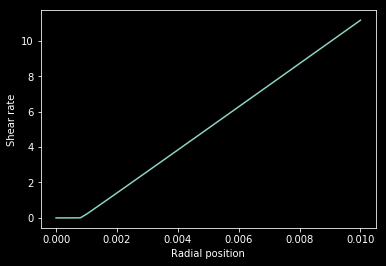

In [53]:
my_3c_pipe.shear_rate_plot()

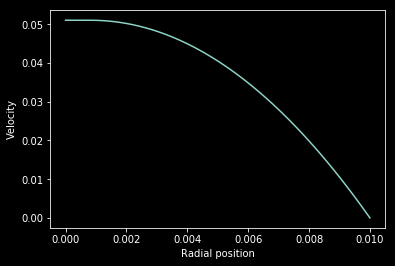

In [54]:
my_3c_pipe.vz_plot()

## Papanastasiou parameter m for yield stress fluids